In [23]:
import baltic as bt
import pandas as pd
import json
import os
import matplotlib as mpl
from matplotlib import pyplot as plt
import requests
from io import StringIO as sio
from matplotlib.patches import Patch
import matplotlib.ticker as ticker
from collections import Counter
import itertools
import re
import sys
import subprocess
from Bio import Phylo
import dendropy

module_dir = "/Users/monclalab1/Documents/scripts/"
sys.path.append(module_dir)

from fasta_editing import fasta_to_df, fasta_writer

list_of_genes = ["ha", "pb2","pb1","na","np","pa","ns","mp"] 

In [17]:
# renaming the treesort inferences (rea1, rea2, rea3...rea(1000)) so baltic can read them in

def renumber_node_trait_blocks(newick_str):
    
    # re.compile lets you make a regex object (see https://www.geeksforgeeks.org/re-compile-in-python/)
    # "Compiling a pattern makes it more efficient when we need to use the same pattern 
    # several times, as it avoids re-compiling the pattern each time." 
    
    pattern = re.compile(r'(\[&[^\]]+\])+')  # multiple [&...] in a row

    def process_all_blocks(cluster):
        
        # each node has multiple traits split into several brackets,
        # so "blocks" collects all of them as strings
        blocks = re.findall(r'\[&[^\]]+\]', cluster.group(0))
        new_blocks = []
        index = 1  # restarts the count for each node

        for block in blocks:
            # inner is each block stipped of [& at the beginning and ] at the end
            # traits is a comma-separated list of each block
            inner = block[2:-1] 
            traits = [trait.strip() for trait in inner.split(',')]
            i = 0
            renamed_traits = []

            while i < len(traits):
                trait = traits[i]
                if trait.startswith('rea='):
                    # must be followed by is_reassorted=1
                    if i + 1 < len(traits) and traits[i + 1] == 'is_reassorted=1':
                        val = trait.split('=', 1)[1]
                        # changing both rea and its associated is_reassorted trait
                        renamed_traits.append(f'rea{index}={val}')
                        renamed_traits.append(f'is_reassorted{index}=1')
                        index += 1
                        i += 2
                        continue
                elif trait.startswith('is_reassorted=0'):
                    renamed_traits.append(f'is_reassorted{index}=0')
                    index += 1
                    i += 1
            
            # rewriting it back to look like treesort annotations
            # since each node has two blocks, this brings them together
            new_blocks.append(f"[&{','.join(renamed_traits)}]")

        # it gets replaced 
        return ''.join(new_blocks)

    # "The re.sub() function in Python's re module can accept a function as its second argument, repl." 
    # re.sub() calls process_all_blocks() function once for every match in the string
    
    # replacements done in process_all_blocks function 
    return pattern.sub(process_all_blocks, newick_str)

with open("prepped/div/outputs/output3_QC.nwk") as f:
    raw_newick = f.read()

updated_newick = renumber_node_trait_blocks(raw_newick)

with open("prepped/div/outputs/output3_renamed.nwk", "w") as f:
    f.write(updated_newick)


In [18]:
mytree = bt.loadNewick('prepped/div/outputs/output3_renamed.nwk', absoluteTime= False)


In [19]:
# now that all the annotations have been renamed, you can load the annotations into a dict

node_annotations_summary = {}

for k in mytree.Objects:
    if k.is_node():
        node_name = k.traits["label"]
    else:
        node_name = k.name
    
    reassorted_count = 0
    nonreassorted_count = 0
    rea_dict = {}
    
    for trait, value in k.traits.items():
        if trait.startswith('is_reassorted'):
            if value == 1.0:
                reassorted_count += 1
            elif value == 0.0:
                nonreassorted_count += 1
        elif trait.startswith('rea'):
            if value in rea_dict:
                rea_dict[value] += 1
            else:
                rea_dict[value] = 1

        node_annotations_summary[node_name] = {
            'reassorted': reassorted_count,
            'nonreassorted': nonreassorted_count,
            'rea': rea_dict
        }


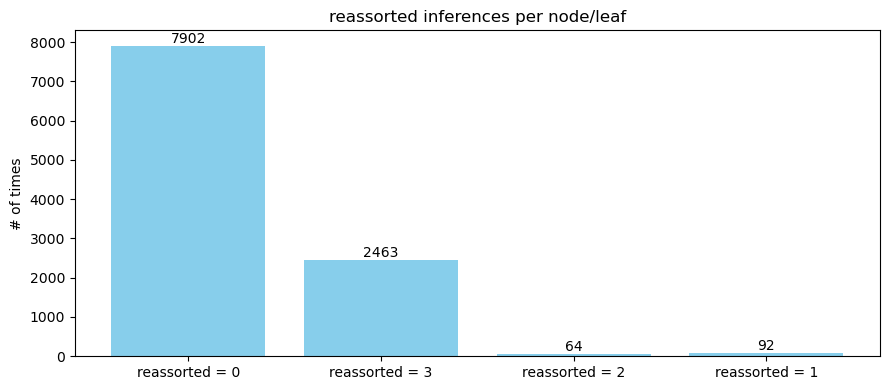

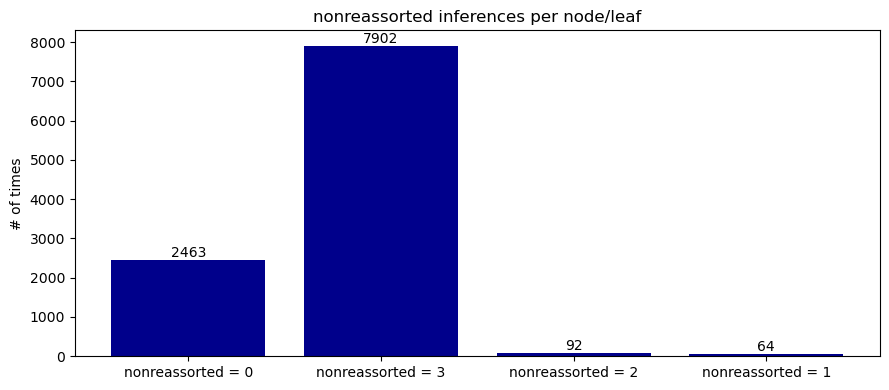

In [20]:
# quick viz of how reassortment events are being inferred

reassorted_counts = Counter()

for node_data in node_annotations_summary.values():
    reassorted = node_data['reassorted']
    reassorted_counts[reassorted] += 1

x_vals = [0, 3, 2, 1]
y_vals = [reassorted_counts.get(x, 0) for x in x_vals]

plt.figure(figsize=(9, 4))
bars = plt.bar([f'reassorted = {x}' for x in x_vals], y_vals, color='skyblue')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height, str(height), 
             ha='center', va='bottom', fontsize=10)

plt.title('reassorted inferences per node/leaf')
plt.ylabel('# of times')
plt.savefig("plots/reassorted_node_leaf_counts.pdf")
plt.tight_layout()
plt.show()

nonreassorted_counts = Counter()

for node_data in node_annotations_summary.values():
    nonreassorted = node_data['nonreassorted']
    nonreassorted_counts[nonreassorted] += 1

x_vals = [0, 3, 2, 1]
y_vals = [nonreassorted_counts.get(x, 0) for x in x_vals]


plt.figure(figsize=(9, 4))
bars = plt.bar([f'nonreassorted = {x}' for x in x_vals], y_vals, color='darkblue')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height, str(height), 
             ha='center', va='bottom', fontsize=10)

plt.title('nonreassorted inferences per node/leaf')
plt.ylabel('# of times')
# plt.savefig("plots/nonreassorted_node_leaf_counts.pdf")
plt.tight_layout()
plt.show()



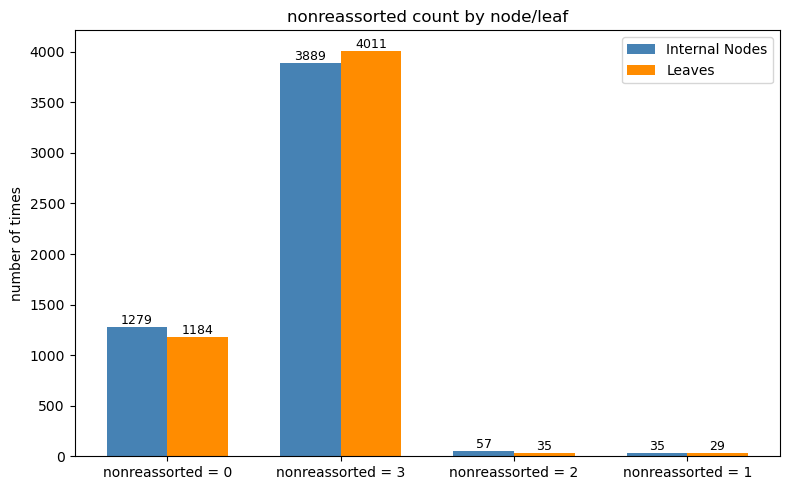

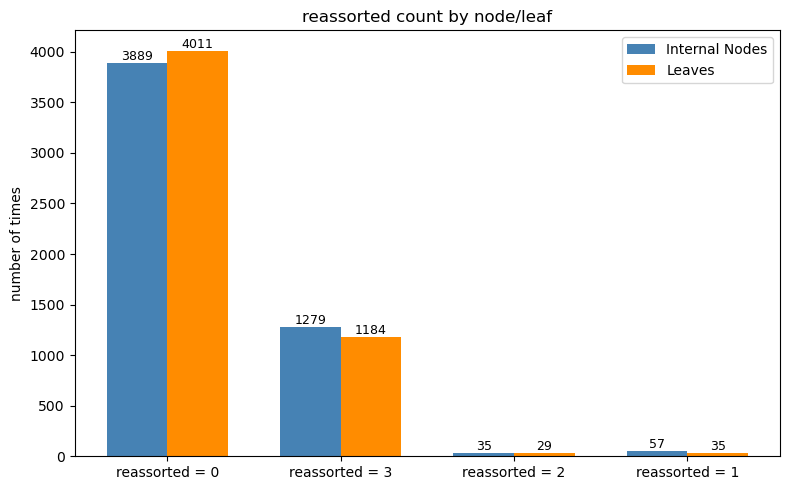

In [21]:
# quick viz of how reassortment events are being inferred separated into nodes/leaves

node_counts = Counter()
leaf_counts = Counter()

node_rea_counts = Counter()
leaf_rea_counts = Counter()

for name, data in node_annotations_summary.items():
    nonreassorted = data['nonreassorted']
    reassorted = data['reassorted']
    if isinstance(name, str):
        if name.startswith('NODE_'):
            node_counts[nonreassorted] += 1
            node_rea_counts[reassorted] += 1
        elif name.lower().startswith('a/'):
            leaf_counts[nonreassorted] += 1
            leaf_rea_counts[reassorted] += 1

# X axis values
x_vals = [0, 3, 2, 1]
x_labels = [f'nonreassorted = {x}' for x in x_vals]

node_y = [node_counts.get(x, 0) for x in x_vals]
leaf_y = [leaf_counts.get(x, 0) for x in x_vals]

x = range(len(x_vals))
width = 0.35

plt.figure(figsize=(8, 5))
bars1 = plt.bar([i - width/2 for i in x], node_y, width=width, label='Internal Nodes', color='steelblue')
bars2 = plt.bar([i + width/2 for i in x], leaf_y, width=width, label='Leaves', color='darkorange')

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height, str(height), ha='center', va='bottom', fontsize=9)

plt.xticks(x, x_labels)
plt.ylabel('number of times')
plt.title('nonreassorted count by node/leaf')
plt.legend()
plt.savefig("plots/nonreassorted_node_leaf_sep_counts.pdf")
plt.tight_layout()
plt.show()


x_labels = [f'reassorted = {x}' for x in x_vals]

node_y = [node_rea_counts.get(x, 0) for x in x_vals]
leaf_y = [leaf_rea_counts.get(x, 0) for x in x_vals]

x = range(len(x_vals))
width = 0.35

plt.figure(figsize=(8, 5))
bars1 = plt.bar([i - width/2 for i in x], node_y, width=width, label='Internal Nodes', color='steelblue')
bars2 = plt.bar([i + width/2 for i in x], leaf_y, width=width, label='Leaves', color='darkorange')

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height, str(height), ha='center', va='bottom', fontsize=9)

plt.xticks(x, x_labels)
plt.ylabel('number of times')
plt.title('reassorted count by node/leaf')
plt.legend()
# plt.savefig("plots/reassorted_node_leaf_sep_counts.pdf")
plt.tight_layout()
plt.show()


In [198]:
# for label, summary in node_annotations_summary.items():
#     print(label, summary)

In [24]:
# making "mcc" tree

tree = dendropy.Tree.get(
    path='trees/tree4.nwk',
    schema="newick",
    preserve_underscores=True
)

for node in tree.preorder_node_iter():
    
    label = str(node.taxon).replace('Taxon(', '').strip(')"\'') if node.is_leaf() else node.label
    
    if label in node_annotations_summary:
        
        info = node_annotations_summary[label]
        
        node.annotations.clear()
        
        
        # what if there were 2 events, 2 different rea annotations? need to account for that
        is_reassorted = 1 if info["reassorted"] >= 2 else 0
        node.annotations.add_new("is_reassorted", is_reassorted)
        
        if is_reassorted and info["rea"]:
            majority_rea = max(info["rea"].items(), key=lambda x: x[1])[0]
            node.annotations.add_new("rea", majority_rea)
      
# for some reason only nexus trees with annotations are able to be read in by figtree
tree.write(path="trees/output.nexus", schema="nexus", suppress_annotations = False)
tree.write(path="trees/output.nwk", schema="newick", suppress_annotations = False)


In [200]:
''' 
1. replaces commas with "-" (where the reassorted segments are inferred)
2. remove the single quotation marks around NODE_####
3. replaces ? with _ (where there is an undetermined reassortment event)
4. converts to nwk
    
'''

def treesort_QC(qc_input, qc_output):
    
    with open(qc_input, 'r') as file:
        nexus = file.read()
        
    start_idx = nexus.find('(')
    modified = nexus[start_idx:]
    
    end_idx = modified.find('END;')
    modified = modified[:end_idx]
        
    # removing commas between segments
    modified = re.sub(r'&rea="([^"]+)"', lambda match: f'&rea="{match.group(1).replace(",", "-")}"', modified)
    
    # removing quotation marks around node names
    modified = re.sub(r"'(NODE_\d+)'", r'\1', modified)
    
    # replacing ? with _ so baltic can read it in
    modified = modified.replace('?', '_')
    
    with open(qc_output, "w") as output_file:
        output_file.write(modified.strip())


treesort_QC("trees/output.nwk", "trees/output_for_baltic.nwk")

mytree = bt.loadNewick('output_for_baltic.nwk', absoluteTime= False)

In [201]:
def plot_rea(mytree):
    
    plt.rcParams["font.family"] = "Arial"

    fig, ax = plt.subplots(figsize=(15, 15))

    x_attr = lambda k: k.x
    
    color_by = lambda k: "red" if k.traits["is_reassorted"] else "black"

    mytree.plotTree(ax, x_attr=x_attr,colour=color_by, width = 3)
    
    mytree.plotPoints(ax,
                   x_attr=x_attr,
                   size= 5,
                   colour=color_by,
                   zorder=2,
                   marker='o'
                     )
    
    legend_elements = [
        Patch(facecolor='red', edgecolor='red', label='Reassorted'),
        Patch(facecolor='black', edgecolor='black', label='Non-reassorted')
    ]
    ax.legend(handles=legend_elements, loc='lower left', fontsize=25, title_fontsize=30)


    ax.set_yticks([])
    ax.set_yticklabels([])
    [ax.spines[loc].set_visible(False) for loc in ax.spines if loc not in ['bottom']]
    ax.tick_params(axis='x',labelsize=30,size=15, width=2,color='grey')
    ax.set_xlabel("Divergence", fontsize=25)
    fig.tight_layout()
     
    plt.savefig("plots/rea.pdf")
    plt.show()
    
    

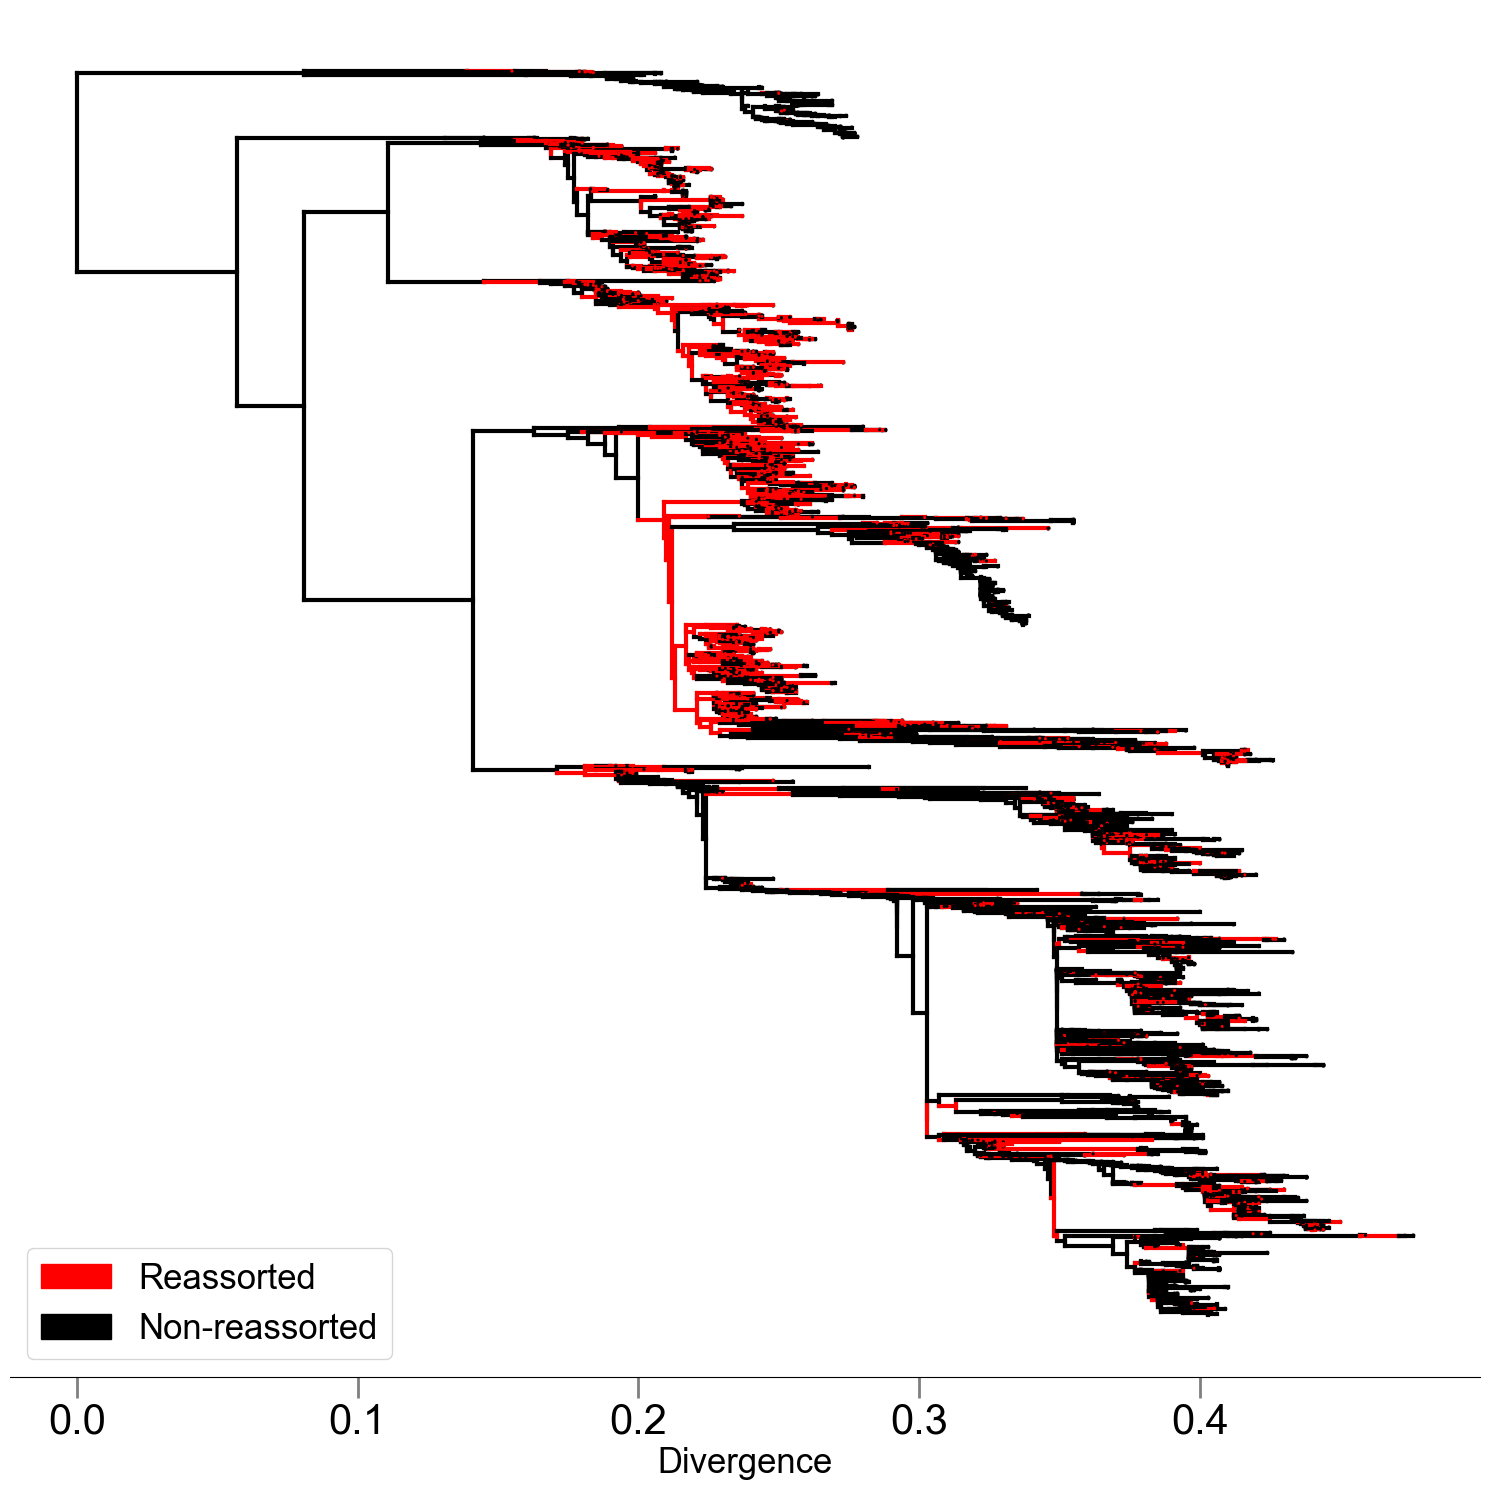

In [202]:
plot_rea(mytree)
